In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from collections import Counter
import numpy as np
import numpy.linalg as LA
import matplotlib
import matplotlib.pyplot as plt
#import geoplot as gplt
import glob
import datetime as dt
import random
from sklearn.cluster import KMeans
import math

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
class flussi():
    impianti_file = 'impianti.csv'
    impianti_df = pd.read_csv(impianti_file).drop('Note', axis = 1)
    geo_start = gpd.points_from_xy(impianti_df['Latitude Start'], impianti_df['Longitude Start'])
    geo_end = gpd.points_from_xy(impianti_df['Latitude Start'], impianti_df['Longitude Start'])
    
    impianti_df = gpd.GeoDataFrame(impianti_df)

    impianti_df['GEO_START'] = geo_start
    impianti_df['GEO_END'] = geo_end
    
    impianto_line = gpd.GeoSeries(impianti_df.apply(lambda row: LineString([row['GEO_START'], row['GEO_END']]), axis=1))
    impianti_df['IMPIANTO_LINE'] = impianto_line

    
    def __init__(self, input_file, sample = None):
        '''Carica il file dei dati ed estrae le quantita di interesse'''
        self.file_name = input_file.split('/')[-1][0:-4]
        self.impianti = self.file_name[11:]
        self.date = self.file_name[0:10]
        
        self.df = pd.read_csv(input_file)
        self.df['DATA_ORA'] = pd.to_datetime(self.df['DATA_ORA'], format = "%d/%m/%Y %H.%M.%S")
            
        self.N = len(self.df)
        
        self.df = pd.merge(self.df, flussi.impianti_df, left_on = 'ID_IMPIANTO', right_on = 'Codice')
        
        geo_start = gpd.points_from_xy(self.df['Latitude Start'], self.df['Longitude Start'])
        geo_end = gpd.points_from_xy(self.df['Latitude End'], self.df['Longitude End'])
        self.df = gpd.GeoDataFrame(self.df)
        self.df['GEO START'] = geo_start
        self.df['GEO END'] = geo_end
        
        if VERBOSE>2:
            print(f'\n Caricato: {self.file_name}. Esempio record prima risalita:')
            print(self.df.loc[0])
        
        if sample:
            self.serie_set = list(set(self.df['SERIE']))
            self.df=self.df[self.df['SERIE'].isin(random.sample(self.serie_set, sample))]
        else:
            self.serie_set = list(set(self.df['SERIE']))
        
        self.cassa = self.df['CASSA']
        self.cassa_set = list(set(self.cassa))
        self.N_casse = len(self.cassa_set)
        self.cassa_counter = Counter(self.cassa)
        
        # la serie e' la ID dello sciatore
        self.serie = self.df['SERIE']
        #self.serie_set = list(set(self.serie))
        self.N_sciatori = len(self.serie_set)
        self.serie_counter = Counter(self.serie)

        self.data_ora = self.df['DATA_ORA']
        self.data_ora_set = list(set(self.data_ora))

        self.pool = self.df['POOL']
        self.pool_set = list(set(self.pool))

        self.impianto = self.df['ID_IMPIANTO']
        self.impianto_set = list(set(self.impianto))
        self.N_impianti = len(self.impianto_set)
        self.impianto_counter = Counter(self.impianto)

        self.lettore = self.df['ID_LETTORE']
        self.lettore_set = list(set(self.lettore))
        
        self.flow_matrix, self.flow_matrices, self.skier_num_runs = self.get_flow_matrix()
        
        if VERBOSE>1:
            print(f'Sommario {self.file_name} -- {self.N} risalite per {self.N_sciatori} sciatori su {self.N_impianti} impianti di risalita.')
        
    def show_stats(self):
        '''Show some basic statistics of the data'''
        
        ## Contare le risalite per sciatore
        corse = np.zeros((self.N_sciatori))
        for i in range(self.N_sciatori):
            corse[i] = self.serie_counter[self.serie_set[i]]
    
        corse = np.flip(np.sort(corse))
        
        
        plt.subplot(1,2,1)
        plt.plot(range(1,self.N_sciatori+1), corse,lw=3,label=self.date)
        plt.xscale('log')
        
        plt.title(f'Risalite per sciatore - {self.impianti}',fontsize=24)
        plt.xlabel('Indice sciatore',fontsize=20)
        plt.ylabel('Numero risalite',fontsize=20)
        
        ## Contare le risalite per impianto
        corse = np.zeros((self.N_impianti))
        for i in range(self.N_impianti):
            corse[i] = self.impianto_counter[self.impianto_set[i]]
    
        corse = np.flip(np.sort(corse))
        
        # plotta le risalite per impianto
        plt.subplot(1,2,2)
        plt.plot(corse,lw=3,label=self.date)
        
        plt.title(f'Risalite per impianto - {self.impianti}',fontsize=24)
        plt.xlabel('Indice impianto',fontsize=20)
        plt.ylabel('Numero risalite',fontsize=20)
        
    def create_sample(self, size):
        return flussi('./file csv/'+self.file_name+'.txt', size)
    
    def build_flow_init(self):
        df = self.df
        zer = np.zeros((len(self.impianto_set),len(self.impianto_set)))
        flow_matrix = pd.DataFrame(data = zer, columns = self.impianto_set)
        flow_matrix['ind'] = self.impianto_set
        flow_matrix.set_index('ind', inplace = True, drop = True)
        return flow_matrix

    def get_flow_matrix(self, num_skiers = None):
        if num_skiers:
            serie_sample = random.sample(self.serie_set, num_skiers)
        else:
            serie_sample = self.serie_set
        
        df = self.df
        flow_matrix = self.build_flow_init()
        flow_matrices={}
        skier_num_runs={}
        
        # loop over each skier
        for s in serie_sample:

            # select the sequence of rides for skier s sorted by time
            ski_day = df[df['SERIE'] == s].sort_values('DATA_ORA')
            skier_num_runs[s] = len(ski_day)
            current_fm = self.build_flow_init()
            flow_matrices[s] = current_fm

            for i in range(len(ski_day) - 1):
                x = ski_day['ID_IMPIANTO'].iloc[i]
                y = ski_day['ID_IMPIANTO'].iloc[i+1]
                flow_matrix[y][x]+=1
                current_fm[y][x]+=1

        return flow_matrix, flow_matrices, skier_num_runs
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0


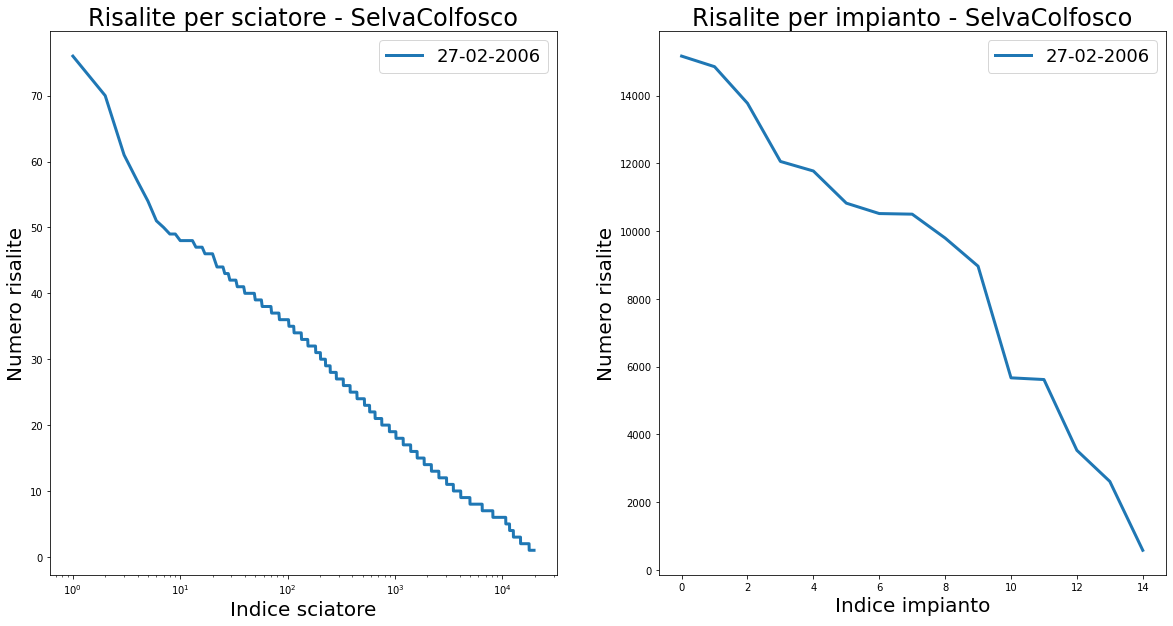

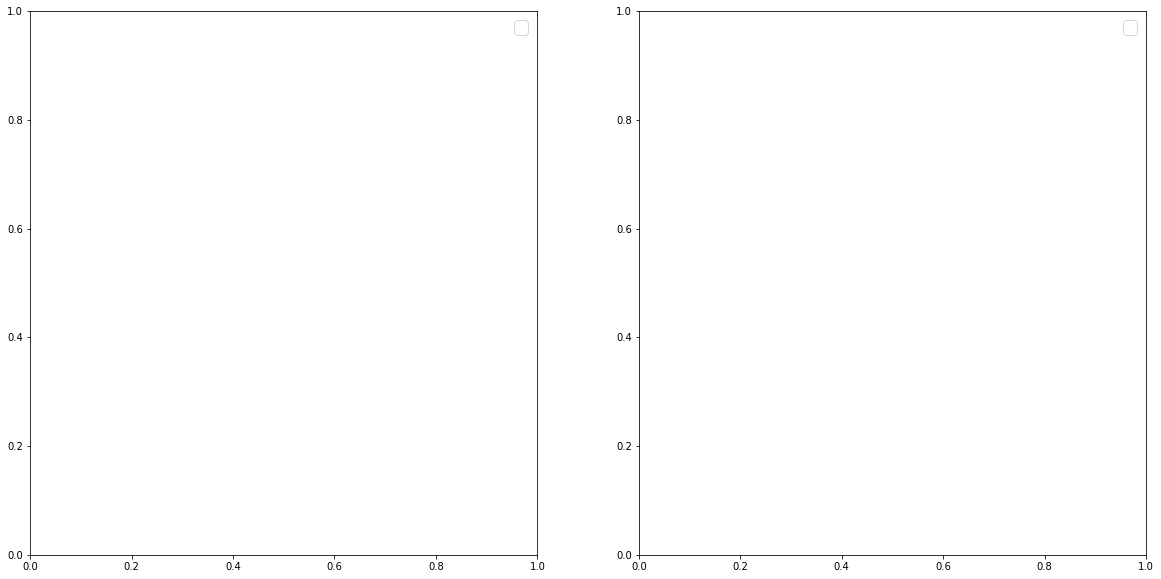

In [3]:
INPUT_DIR = './file csv/'
FILE_STRINGS = ['2006-SelvaColfosco','2006-Selva']
VERBOSE = 0

k=0
dataset_list = []
for str in FILE_STRINGS: ## each str is a group of files

    INPUT_FILES = glob.glob(INPUT_DIR + f'*{str}.txt') # group of files chosen by str

    fig = plt.figure(figsize=(20,10))
   
    for f in INPUT_FILES[4:5]:
        fl = flussi(f)
        fl.show_stats()
        dataset_list.append(fl)
        print(k)
        k+=1
    
    for i in range(1,3):
        plt.subplot(1,2,i)
        plt.legend(fontsize=18)

In [4]:
dataset_list[0].df

,CASSA,SERIE,DATA_ORA,POOL,ID_IMPIANTO,ID_LETTORE,Codice,Nome,Latitude Start,Longitude Start,Latitude End,Longitude End,Length,GEO_START,GEO_END,IMPIANTO_LINE,GEO START,GEO END
0,72,23153,2006-02-27 08:28:00,1,175,3,175,Borest,46.548524,11.870785,46.549766,11.857081,"1,056.27",POINT (46.54852 11.87078),POINT (46.54852 11.87078),"LINESTRING (46.54852 11.87078, 46.54852 11.87078)",POINT (46.54852 11.87078),POINT (46.54977 11.85708)
1,73,26010,2006-02-27 08:28:00,1,175,1,175,Borest,46.548524,11.870785,46.549766,11.857081,"1,056.27",POINT (46.54852 11.87078),POINT (46.54852 11.87078),"LINESTRING (46.54852 11.87078, 46.54852 11.87078)",POINT (46.54852 11.87078),POINT (46.54977 11.85708)
2,72,23159,2006-02-27 08:28:00,1,175,2,175,Borest,46.548524,11.870785,46.549766,11.857081,"1,056.27",POINT (46.54852 11.87078),POINT (46.54852 11.87078),"LINESTRING (46.54852 11.87078, 46.54852 11.87078)",POINT (46.54852 11.87078),POINT (46.54977 11.85708)
3,72,23161,2006-02-27 08:28:00,1,175,4,175,Borest,46.548524,11.870785,46.549766,11.857081,"1,056.27",POINT (46.54852 11.87078),POINT (46.54852 11.87078),"LINESTRING (46.54852 11.87078, 46.54852 11.87078)",POINT (46.54852 11.87078),POINT (46.54977 11.85708)
4,72,23155,2006-02-27 08:30:00,1,175,1,175,Borest,46.548524,11.870785,46.549766,11.857081,"1,056.27",POINT (46.54852 11.87078),POINT (46.54852 11.87078),"LINESTRING (46.54852 11.87078, 46.54852 11.87078)",POINT (46.54852 11.87078),POINT (46.54977 11.85708)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136241,101,50546,2006-02-27 16:58:00,1,392,2,392,Val,46.561839,11.770777,46.557378,11.777392,707.83,POINT (46.56184 11.77078),POINT (46.56184 11.77078),"LINESTRING (46.56184 11.77078, 46.56184 11.77078)",POINT (46.56184 11.77078),POINT (46.55738 11.77739)
136242,101,50548,2006-02-27 16:58:00,1,392,1,392,Val,46.561839,11.770777,46.557378,11.777392,707.83,POINT (46.56184 11.77078),POINT (46.56184 11.77078),"LINESTRING (46.56184 11.77078, 46.56184 11.77078)",POINT (46.56184 11.77078),POINT (46.55738 11.77739)
136243,103,22802,2006-02-27 17:01:00,1,392,2,392,Val,46.561839,11.770777,46.557378,11.777392,707.83,POINT (46.56184 11.77078),POINT (46.56184 11.77078),"LINESTRING (46.56184 11.77078, 46.56184 11.77078)",POINT (46.56184 11.77078),POINT (46.55738 11.77739)
136244,108,16307,2006-02-27 17:01:00,1,392,1,392,Val,46.561839,11.770777,46.557378,11.777392,707.83,POINT (46.56184 11.77078),POINT (46.56184 11.77078),"LINESTRING (46.56184 11.77078, 46.56184 11.77078)",POINT (46.56184 11.77078),POINT (46.55738 11.77739)


In [5]:
flussi.impianti_df

,Codice,Nome,Latitude Start,Longitude Start,Latitude End,Longitude End,Length,GEO_START,GEO_END,IMPIANTO_LINE
0,175,Borest,46.548524,11.870785,46.549766,11.857081,"1,056.27",POINT (46.54852 11.87078),POINT (46.54852 11.87078),"LINESTRING (46.54852 11.87078, 46.54852 11.87078)"
1,176,Borest Rit,46.549766,11.857081,46.548524,11.870785,"1,056.27",POINT (46.54977 11.85708),POINT (46.54977 11.85708),"LINESTRING (46.54977 11.85708, 46.54977 11.85708)"
2,177,Sodlisia,46.550120,11.845326,46.549922,11.855720,794.54,POINT (46.55012 11.84533),POINT (46.55012 11.84533),"LINESTRING (46.55012 11.84533, 46.55012 11.84533)"
3,180,Plans,46.547991,11.843061,46.555936,11.812015,"2,531.18",POINT (46.54799 11.84306),POINT (46.54799 11.84306),"LINESTRING (46.54799 11.84306, 46.54799 11.84306)"
4,182,Frara,46.548174,11.827447,46.555936,11.812015,"1,460.90",POINT (46.54817 11.82745),POINT (46.54817 11.82745),"LINESTRING (46.54817 11.82745, 46.54817 11.82745)"
5,186,Colfosco,46.550314,11.853338,46.562385,11.850872,"1,354.38",POINT (46.55031 11.85334),POINT (46.55031 11.85334),"LINESTRING (46.55031 11.85334, 46.55031 11.85334)"
6,220,Ciampinoi,46.553097,11.761725,46.538755,11.753416,"1,715.42",POINT (46.55310 11.76172),POINT (46.55310 11.76172),"LINESTRING (46.55310 11.76172, 46.55310 11.76172)"
7,221,Dantercepies,46.555676,11.767955,46.553689,11.799795,"2,442.85",POINT (46.55568 11.76795),POINT (46.55568 11.76795),"LINESTRING (46.55568 11.76795, 46.55568 11.76795)"
8,222,Costabella,46.552438,11.764028,46.552505,11.769349,406.68,POINT (46.55244 11.76403),POINT (46.55244 11.76403),"LINESTRING (46.55244 11.76403, 46.55244 11.76403)"
9,225,Larciunei,46.557724,11.763794,46.556665,11.766544,240.75,POINT (46.55772 11.76379),POINT (46.55772 11.76379),"LINESTRING (46.55772 11.76379, 46.55772 11.76379)"


In [6]:
def build_flow_init(flusso):
    df = flusso.df
    zer = np.zeros((len(flusso.impianto_set),len(flusso.impianto_set)))
    flow_matrix = pd.DataFrame(data = zer, columns = flusso.impianto_set)
    flow_matrix['ind'] = flusso.impianto_set
    flow_matrix.set_index('ind', inplace = True, drop = True)
    return flow_matrix

def get_flow_matrix(flusso, num_skiers = None):
    if num_skiers:
        serie_sample = random.sample(flusso.serie_set, num_skiers)
    else:
        serie_sample = flusso.serie_set
    
    df = flusso.df
    flow_matrix = build_flow_init(flusso)
    flow_matrices={}
    skier_num_runs={}
    
    print(flusso.N)
    
    # loop over each skier
    for s in serie_sample:
        
        # select the sequence of rides for skier s sorted by time
        ski_day = df[df['SERIE'] == s].sort_values('DATA_ORA')
        skier_num_runs[s] = len(ski_day)
        current_fm = build_flow_init(dataset_list[0])
        flow_matrices[s] = current_fm
    
        for i in range(len(ski_day) - 1):
            x = ski_day['ID_IMPIANTO'].iloc[i]
            y = ski_day['ID_IMPIANTO'].iloc[i+1]
            flow_matrix[y][x]+=1
            current_fm[y][x]+=1
            
    return flow_matrix, flow_matrices, skier_num_runs

In [7]:
def get_skier_diff(flusso, num_skiers = None):
    #flow_matrix = flusso.flow_matrix
    flow_matrices = flusso.flow_matrices
    skier_num_runs = flusso.skier_num_runs

    if num_skiers:
        serie_sample = random.sample(list(flusso.skier_num_runs.keys()), num_skiers)
    else:
        serie_sample = list(flusso.skier_num_runs.keys())
    
    #df = flusso.df
    
    zer = np.zeros((len(serie_sample),len(serie_sample)))
    diff_matrix = pd.DataFrame(data = zer, columns = serie_sample)
    diff_matrix['ind'] = list(serie_sample)
    diff_matrix.set_index('ind', inplace = True, drop = True)
    
    k=1
    for i in serie_sample:
        for j in serie_sample[k:]:
            #dist = LA.norm(flow_matrices[i] - flow_matrices[j])
            #diff_runs = np.abs(skier_num_runs[i] - skier_num_runs[j])
            #num_runs = skier_num_runs[i] + skier_num_runs[j]
            #diff_matrix[j][i] = (dist + (1/num_runs)) / (num_runs/2)
            i_log = np.log2(flow_matrices[i].to_numpy()+1)
            j_log = np.log2(flow_matrices[j].to_numpy()+1)
            diff_matrix[j][i] = LA.norm(i_log - j_log)
            diff_matrix[i][j] = LA.norm(i_log - j_log)
        #print(k,'/',len(serie_sample))
        k+=1
    return diff_matrix

In [8]:
dist_df = get_skier_diff(dataset_list[0], 100)
dist_df

,18746,32374,3342,42475,2087,27697,58237,34263,28339,30312,...,22348,24344,58808,26246,37733,45871,1547,7258,7470,23435
ind,,,,,,,,,,,,,,,,,,,,,
18746,0.000000,3.223562,2.645751,1.414214,1.414214,2.000000,1.414214,2.645751,2.828427,1.530419,...,1.414214,2.645751,2.645751,2.236068,3.812652,2.236068,1.000000,1.000000,1.000000,3.004033
32374,3.223562,0.000000,3.659419,2.896783,3.223562,3.223562,2.896783,3.659419,4.048623,3.450139,...,2.896783,3.923181,3.659419,3.375107,4.788285,3.375107,3.064531,3.064531,3.064531,3.926266
3342,2.645751,3.659419,0.000000,2.236068,2.645751,2.645751,2.236068,2.449490,3.000000,2.917551,...,2.236068,3.464102,2.449490,2.000000,3.632694,2.000000,2.449490,2.449490,2.449490,2.975615
42475,1.414214,2.896783,2.236068,0.000000,1.414214,1.414214,0.000000,2.236068,2.828427,1.874061,...,0.000000,2.645751,2.236068,1.732051,3.812652,1.732051,1.000000,1.000000,1.000000,2.650323
2087,1.414214,3.223562,2.645751,1.414214,0.000000,1.414214,1.414214,2.645751,2.449490,1.530419,...,1.414214,2.236068,2.645751,2.236068,3.812652,2.236068,1.000000,1.000000,1.000000,3.004033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45871,2.236068,3.375107,2.000000,1.732051,2.236068,2.236068,1.732051,2.000000,2.645751,2.551883,...,1.732051,3.162278,2.000000,2.000000,3.346112,0.000000,2.000000,2.000000,2.000000,2.618069
1547,1.000000,3.064531,2.449490,1.000000,1.000000,1.732051,1.000000,2.449490,2.645751,1.158525,...,1.000000,2.449490,2.449490,2.000000,3.679174,2.000000,0.000000,0.000000,0.000000,2.832704
7258,1.000000,3.064531,2.449490,1.000000,1.000000,1.732051,1.000000,2.449490,2.645751,1.158525,...,1.000000,2.449490,2.449490,2.000000,3.679174,2.000000,0.000000,0.000000,0.000000,2.832704


<function matplotlib.pyplot.show(close=None, block=None)>

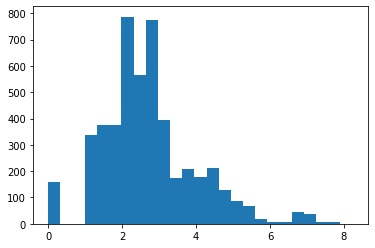

In [9]:
dist_mat = dist_df.to_numpy()
dist_arr = np.array([])
for i in range(len(dist_mat)):
    for j in range(i+1,len(dist_mat)):
        dist_arr = np.append(dist_arr, dist_mat[i][j])
plt.hist(dist_arr, bins = 25)
plt.show

In [72]:
flusso = dataset_list[0]
X = np.empty((0,flusso.N_impianti**2), int)
X_log = np.empty((0,flusso.N_impianti**2), int)
X_norm = np.empty((0,flusso.N_impianti**2), int)
for serie in flusso.serie_set:
    fm_unrolled = flusso.flow_matrices[serie].to_numpy().ravel()
    X = np.append(X, [fm_unrolled], axis = 0)
    X_log = np.append(X, [np.log(fm_unrolled+1)], axis = 0)
    X_norm = np.append(X, [fm_unrolled/np.max(fm_unrolled)], axis = 0)

/var/folders/21/flqpgr7x45s3tfyly7hcxr400000gn/T/ipykernel_25931/189663216.py:9: RuntimeWarning: invalid value encountered in true_divide
  X_norm = np.append(X, [fm_unrolled/np.max(fm_unrolled)], axis = 0)


In [73]:
U,s,VT=LA.svd(X)

KeyboardInterrupt: 

In [74]:
kmeans = KMeans(n_clusters=12, random_state=0).fit(X)
kmeans_log = KMeans(n_clusters=12, random_state=0).fit(X_log)
kmeans_norm = KMeans(n_clusters=12, random_state=0).fit(X_norm)
centroids = [cent.reshape((flusso.N_impianti, flusso.N_impianti)) for cent in kmeans.cluster_centers_]
centroids_log = [cent.reshape((flusso.N_impianti, flusso.N_impianti)) for cent in kmeans_log.cluster_centers_]
#centroids_norm = [cent.reshape((flusso.N_impianti, flusso.N_impianti)) for cent in kmeans_norm.cluster_centers_]

In [75]:
def centroids_as_flow_mat(cent_list):
    flow_mat_list = []
    for c in cent_list:
        c_trunc = np.trunc(c*10)/10
        c_flow_matrix = pd.DataFrame(data = c_trunc, columns = flusso.impianto_set)
        c_flow_matrix['ind'] = flusso.impianto_set #flusso needs to be parameterized
        c_flow_matrix.set_index('ind', inplace = True, drop = True)
        flow_mat_list.append(c_flow_matrix)
    return flow_mat_list

In [76]:
'''x = [np.dot(x_i, VT.T[0]) for x_i in X] #check if these are actually the PCs
y = [np.dot(x_i, VT.T[1]) for x_i in X]
plt.scatter(x = x, y = y)
for c in centroids:
    plt.scatter( np.dot(c.ravel(), VT.T[0]), np.dot(c.ravel(), VT.T[1]), c = 'r')

plt.show()'''

"x = [np.dot(x_i, VT.T[0]) for x_i in X] #check if these are actually the PCs\ny = [np.dot(x_i, VT.T[1]) for x_i in X]\nplt.scatter(x = x, y = y)\nfor c in centroids:\n    plt.scatter( np.dot(c.ravel(), VT.T[0]), np.dot(c.ravel(), VT.T[1]), c = 'r')\n\nplt.show()"

In [79]:
def plot_impianti(ax = None):
    for row in flussi.impianti_df.iterrows():
        lat_start  = row[1]['Latitude Start']
        long_start = row[1]['Longitude Start']
        lat_end    = row[1]['Latitude End']
        long_end   = row[1]['Longitude End']
        
        mid_lat = np.mean([lat_start, lat_end])
        mid_long = np.mean([long_start, long_end])
        
        geometry = LineString([(long_start, lat_start),(long_end, lat_end)])
        gdf = gpd.GeoDataFrame(geometry=[geometry])
        ax = gdf.plot(ax = ax, lw = 2.5, color='k', figsize = (12,12))
        ax.text(s=row[1]['Nome'],x = mid_long, y = mid_lat)
    return ax

def plot_flow_matrix(kmeans, flow_matrix, ax, cent_i = None):
    max_flow = flow_matrix.max().max()
    
    ax = plot_impianti(ax)
    idf = flussi.impianti_df

    thresh = 0.05
    
    for i in flow_matrix:
        for j in flow_matrix:
            if flow_matrix[i][j]/max_flow < thresh:
                continue

            row_i = idf[idf['Codice'] == i]
            row_j = idf[idf['Codice'] == j]
            
            #print(int(row_j['Latitude Start']))
            
            lat_start  = float(row_i['Latitude Start'])
            long_start = float(row_i['Longitude Start'])
            lat_end    = float(row_j['Latitude End'])
            long_end   = float(row_j['Longitude End'])
            
            #print(lat_start, long_start, lat_end, long_end  )

            mid_lat = np.mean([lat_start, lat_end])
            mid_long = np.mean([long_start, long_end])
            
            geometry = LineString([(long_start, lat_start),(long_end, lat_end)])
            gdf = gpd.GeoDataFrame(geometry=[geometry])
            
            
            ax = gdf.plot(ax = ax, lw = 7*flow_matrix[i][j]/max_flow, figsize = (12,12), color='r', alpha = 0.5)

    if cent_i != None:
        n_in_cent = Counter(kmeans.labels_)[cent_i]
        ax.set_title(f'Max = {max_flow}, n = {n_in_cent}', fontsize = 18)
            
            
def plot_centroids(kmeans, centroids):
    f = plt.figure(figsize=(20,80))
    len_cent = len(centroids)
    for i, cent in enumerate(centroids):
        ax = f.add_subplot(len_cent, 1, i+1)
        plot_flow_matrix(kmeans, cent, ax, i)
    f.suptitle('K-Means Centroids', fontsize = 28, y=0.9)
    plt.show()

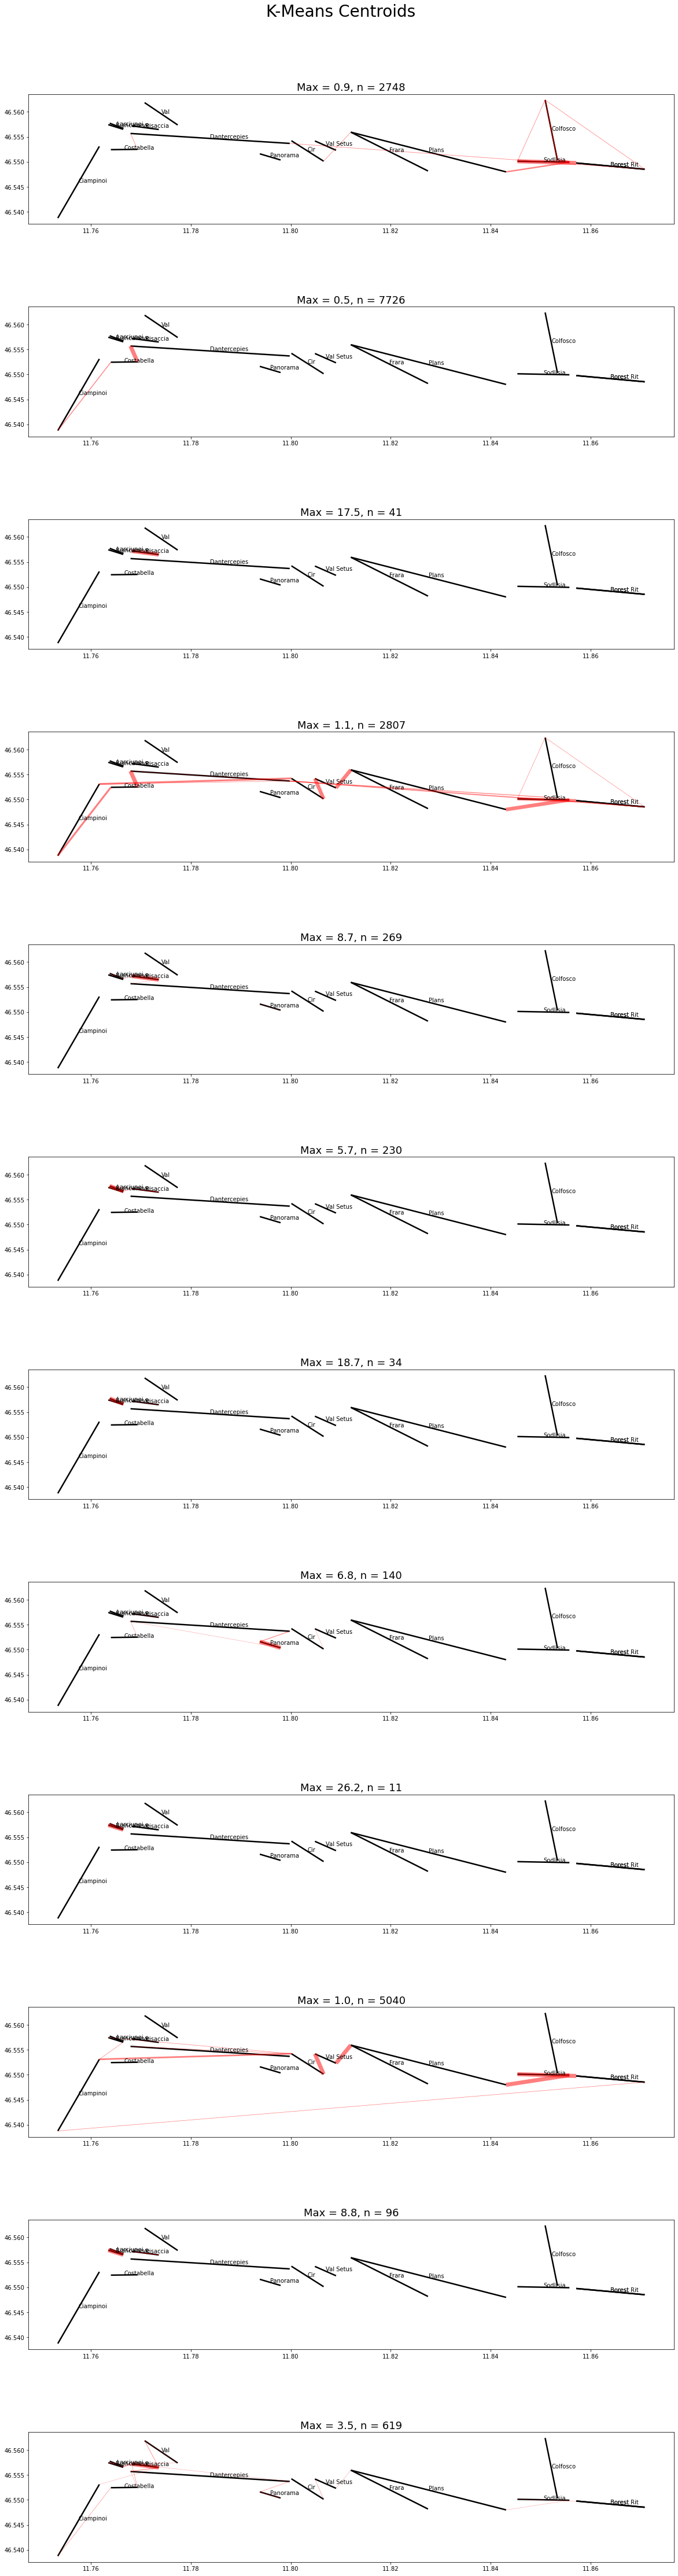

In [78]:
plot_centroids(kmeans, centroids_as_flow_mat(centroids))

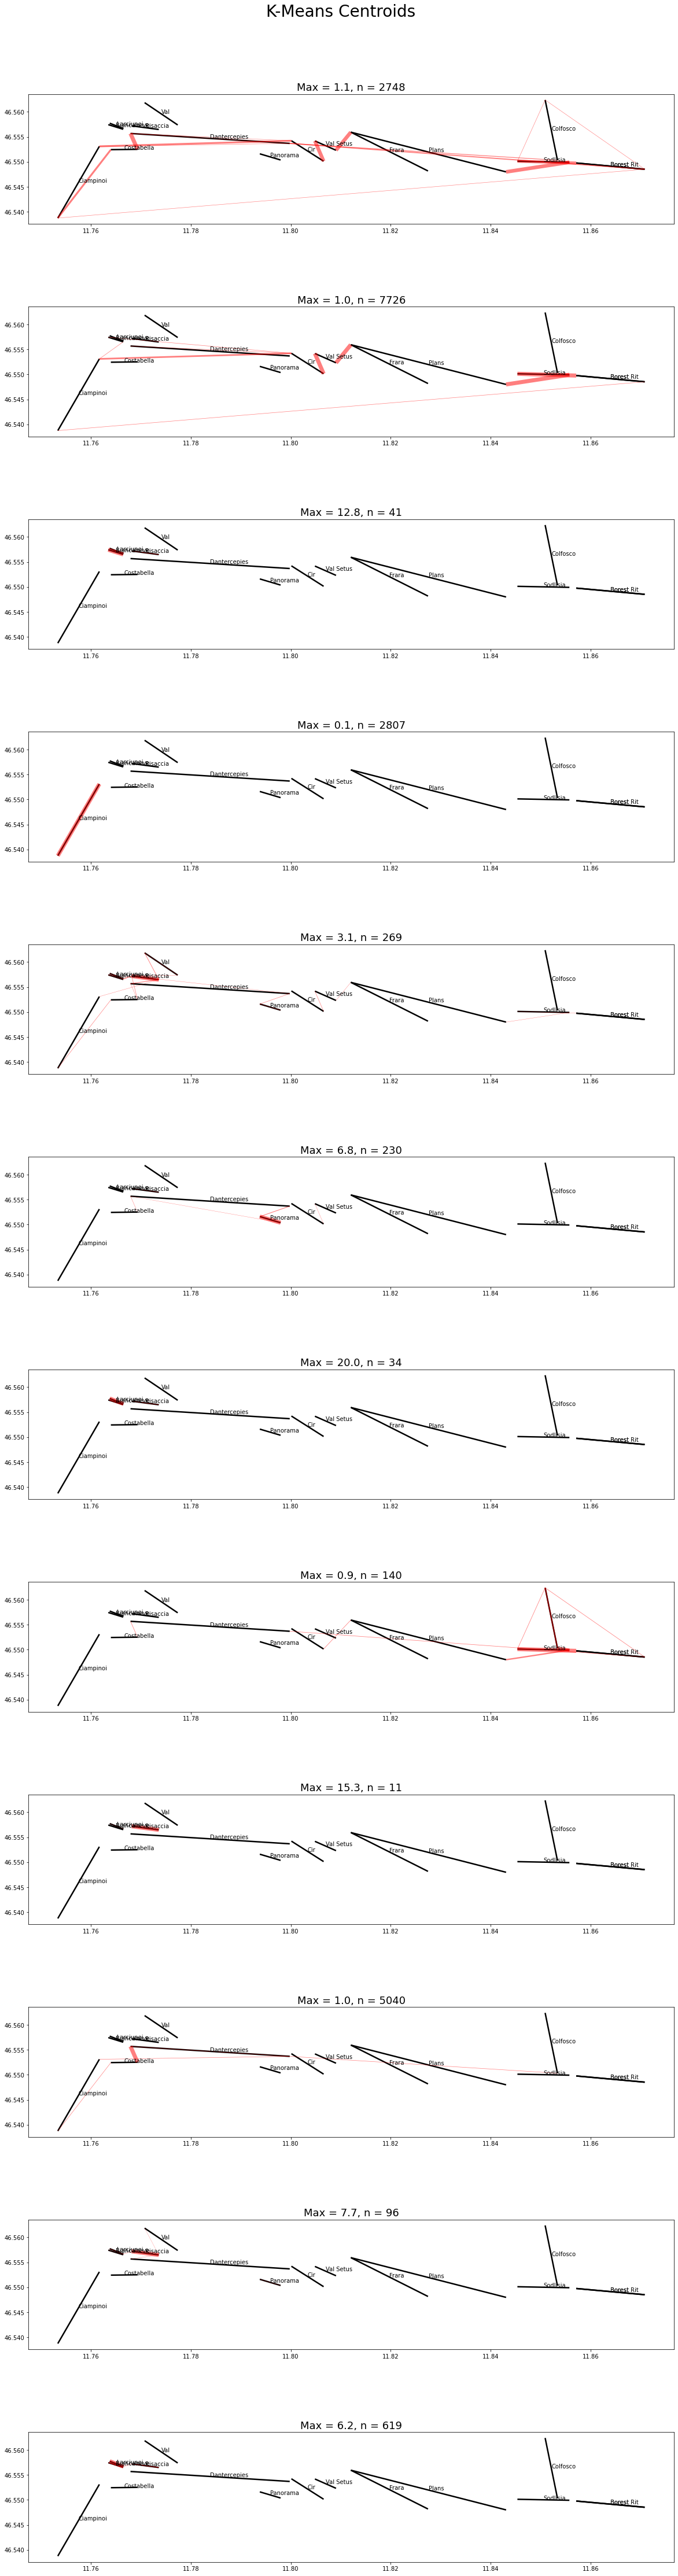

In [77]:
plot_centroids(kmeans, centroids_as_flow_mat(centroids_log))

In [ ]:
plot_centroids(kmeans, centroids_as_flow_mat(centroids_norm))

In [51]:
if 0 != None:
    print('a')

a


In [ ]:
flow_matrix = centroids_as_flow_mat(centroids)[1]
for i in flow_matrix:
    for j in flow_matrix.keys():
        print(flow_matrix[i][j])

In [ ]:
flussi.impianti_df

In [ ]:
def last_run_before_time(imp_entrances, time):
    '''
    Finds last entrance in IMP_ENTRANCES before TIME.
    
    parameters:
    IMP_ENTRANCES: a dataframe of a specific skiers entrances onto a specific lift
             TIME: the threshold time
             
    returns:
        I: The index of the last entrance in IMP_ENTRANCES before TIME
    DELTA: The time difference between the desired entrance and TIME
    '''
    delta = dt.timedelta(0)
    t = imp_entrances['DATA_ORA'].iloc[0]
    i = 0
    while t < time and i < len(imp_entrances) - 1:
        i+=1
        delta = time - t
        t = imp_entrances['DATA_ORA'].iloc[i]
    return i, delta

def sellar_anti_class(day, inter_ids):
    '''
    Tries to find skiers who are on the anticlockwise sellaronda on day with index DAY, by examining time
    delta between skiers entrances onto Borest and Ciampinoi. Returns number of rides on lifts given by
    INTER_IDS between Borest and Ciampinoi.
    
    parameters:
          DAY: The index of the day to be analyzed in DATASET_LIST
    INTER_IDS: ID_IMPIANTO of the lifts whose intermediate rides should be counted
    
    returns:
    
    '''
    flusso = dataset_list[day]
    df = flusso.df

    delta_arr = np.array([])
    num_danter_arr = np.array([])
    
    inter_counts = {}
    for inter_id in inter_ids:
        inter_counts[inter_id] = np.array([])

    k=0
    for s in flusso.serie_set:
        if k % 1000 == 0:
            print(k, '/', len(flusso.serie_set))
        k+=1

        ski_day = df[df['SERIE'] == s]
        borest = ski_day[ski_day['ID_IMPIANTO'] == 175]
        ciampi = ski_day[ski_day['ID_IMPIANTO'] == 220]
        
        danter = ski_day[ski_day['ID_IMPIANTO'] == 221]
        cir = ski_day[ski_day['ID_IMPIANTO'] == 232]

        if len(borest) == 0 or len(ciampi) == 0:
            continue

        i, delta = last_run_before_time(borest, ciampi['DATA_ORA'].iloc[0])
        last_borest_time = borest['DATA_ORA'].iloc[i]

        if delta == dt.timedelta(0):
            continue

        def num_inter_runs(inter_id):
            inter_all = ski_day[ski_day['ID_IMPIANTO'] == inter]
            inter_lower = inter_all[inter_all['DATA_ORA'] > last_borest_time]
            inter = inter_lower[inter_lower['DATA_ORA'] < ciampi['DATA_ORA'].iloc[0]]
            return inter
        
        for inter_id in inter_ids:
            ic_arr = inter_counts[inter_id]
            ic_arr = np.append(ic_arr, num_inter_runs(inter_id))

        delta = delta.total_seconds()//60

        delta_arr = np.append(delta_arr, delta)
        
        return delta_arr, 

In [ ]:
plt.hist(num_danter_arr[num_danter_arr>0])
plt.show()

In [ ]:
flusso = dataset_list[6]
df = flusso.df
df['DATA_ORA'][0] - df['DATA_ORA'][120449] > dt.timedelta(0)

In [ ]:
def create_date_range(date_times, is_set = False):
    '''
    parameters:
    DATE_TIMES: Series or set of datetimes
    IS_SET: set to True if DATE_TIMES is a set
    
    return value: a list of datetimes ranging from 
    the earliest to the latest time in DATE_TIMES
    with frequency of one minute
    '''
    if not is_set:
        dt_set = set(date_times)
    else:
        dt_set = date_times
    return pd.date_range(min(dt_set), max(dt_set), freq = 'T')

def skier_path_matrix(flusso, num_skiers = None):
    #TEMP:
    #day_frame = day_frame[day_frame['SERIE'] == 33022]
    day_frame = flusso.df
    if num_skiers:
        day_frame = flusso.df[flusso.df['SERIE'] == random.sample(flusso.serie_set, num_skiers)]
    
    serie = day_frame['SERIE']
    serie_set = list(set(serie))
    data_ora = day_frame['DATA_ORA']
    data_ora_set = set(data_ora)
    impianti = day_frame['ID_IMPIANTO']
    
    dr = create_date_range(data_ora_set, is_set = True)
    
    matrix = pd.DataFrame(columns = dr)
    matrix_norm = pd.DataFrame(columns = np.arange(len(dr)))
    
    k = 0
    max_day = 0
    for skier in serie_set:
        k+=1
        if k%1000 == 0:
            print(f'{k}/{len(serie_set)}')
        ski_day = day_frame[serie == skier].sort_values('DATA_ORA')
        ski_day_ore = ski_day['DATA_ORA']
        
        #print(ski_day)
        
        td_init = int((ski_day_ore.iloc[0] - dr[0]).total_seconds()/60)
        impianti_skier = np.array(np.zeros(td_init))
            
        i=-1
        day_len = 0
        for i in range(len(ski_day) - 1):
            td = int((ski_day_ore.iloc[i+1] - ski_day_ore.iloc[i]).total_seconds()/60)
            to_add = np.full(shape = td, fill_value = ski_day['ID_IMPIANTO'].iloc[i])
            impianti_skier = np.append(impianti_skier, to_add)
            
            day_len += td
        
        if day_len > max_day:
            max_day = day_len
            max_skier = skier
        
        #print(f'len diff: {len(dr) - len(impianti_skier)}, i: {i}, skier: {skier}')
        
        impianti_skier_norm = impianti_skier[td_init:]
        
        fv = ski_day['ID_IMPIANTO'].iloc[i+1]
        fill_norm = np.full(shape = len(dr) - len(impianti_skier_norm), fill_value = fv)
        fill = fill_norm[td_init:]
        
        impianti_skier_norm = np.append(impianti_skier_norm, fill_norm)
        #print(len(impianti_skier_norm), impianti_skier_norm)
        impianti_skier = np.append(impianti_skier, fill)

        matrix.loc[skier] = impianti_skier
        matrix_norm.loc[skier] = impianti_skier_norm
        
    return matrix, matrix_norm

In [ ]:
def skier_path_matrix_latlong(day_frame, num_skiers):
    day_frame = flusso.df
    if num_skiers:
        day_frame = flusso.df[flusso.df['SERIE'].isin(random.sample(flusso.serie_set, num_skiers))]
    
    serie = day_frame['SERIE']
    serie_set = list(set(serie))
    data_ora = day_frame['DATA_ORA']
    data_ora_set = set(data_ora)
    impianti = day_frame['ID_IMPIANTO']
    
    dr = create_date_range(data_ora_set, is_set = True)
    
    matrix = pd.DataFrame(columns = [dr,dr])
    #matrix_norm = pd.DataFrame(columns = np.arange(len(dr)))
    
    k = 0
    max_day = 0
    for skier in serie_set:
        print(skier)
    return matrix
        

In [ ]:
skier_path_matrix_latlong(dataset_list[6].df, 100)

In [ ]:
x = skier_path_matrix(dataset_list[6].df, 100)[0]

In [ ]:
spm = x
a,b=0,0
for i in spm.iterrows():
    for j in spm.iterrows():
        dist = 0
        for k in range(len(i[1])):
            i_pos = get_pos(i[1].iloc[k])
            j_pos = get_pos(j[1].iloc[k])
            dist += get_dist(i_pos, j_pos)
                

In [ ]:
flusso = dataset_list[6]

dat = flusso.df[flusso.df['SERIE'].isin(random.sample(flusso.serie_set, 5))]
dat.sort_values('SERIE')

In [ ]:
a=[i for i in [1,2,3] if i in [1,2]]


a

In [ ]:
next(flusso.df.iterrows())[1]['SERIE']